In [73]:
# import libraries

# frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# basic
import numpy as np
import copy

# visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [74]:
# import our dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')
data.shape

(20000, 785)

In [75]:
# split data
labels = data[:, 0]
ndata = data[:, 1:]

print(labels.shape, ndata.shape)

(20000,) (20000, 784)


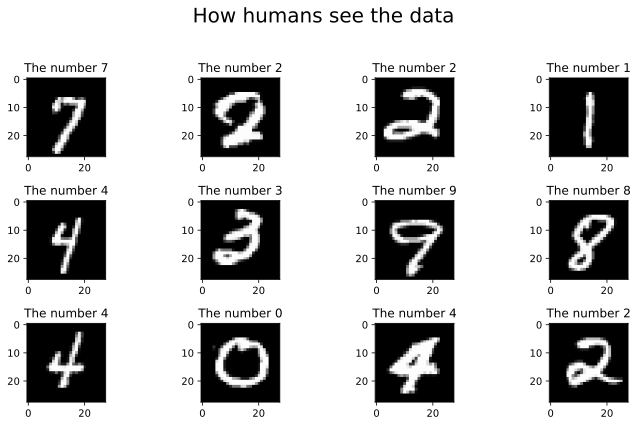

In [118]:
# show a few random digits - Humans
fig,axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0, high=ndata.shape[0])

  # create the image (must be reshaped!)
  img = np.reshape(ndata[randimg2show,:], (28, 28))
  ax.imshow(img, cmap='gray')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How humans see the data', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

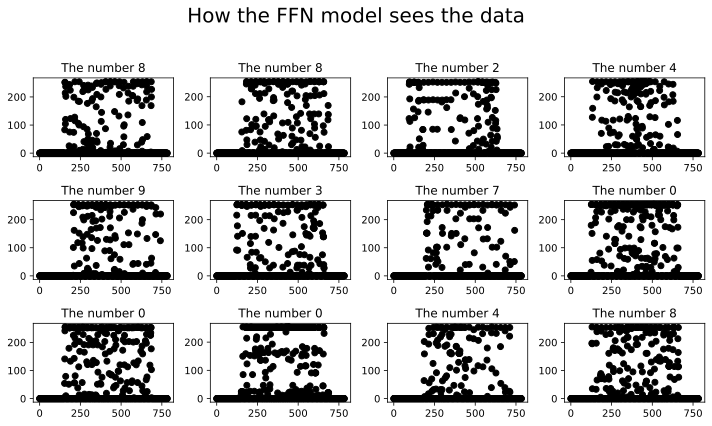

In [119]:
# show a few random digits - Machine
fig,axs = plt.subplots(3, 4, figsize=(10, 6))

for ax in axs.flatten():
  # pick a random image
  randimg2show = np.random.randint(0, high=ndata.shape[0])

  # create the image
  ax.plot(ndata[randimg2show,:], 'ko')

  # title
  ax.set_title('The number %i'%labels[randimg2show])

plt.suptitle('How the FFN model sees the data',fontsize=20)
plt.tight_layout(rect=[0, 0, 1, .95])
plt.show()

In [76]:
# normalize the data, put everthing in range between 0 and 1
dataNorm = ndata / np.max(ndata)
# ndata, dataNorm

In [82]:
# Create the train, test datasets

# 1 -  convert to tensor
dataT = torch.tensor( dataNorm ).float()
labelsT = torch.tensor( labels ).long()

# 2 -  split with sklearn
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labelsT, test_size=.3)
dev_data, test_data, dev_labels, test_labels = train_test_split(test_data, test_labels, test_size=.6)

# 3 -  convert into PyTorch Datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)
dev_data = TensorDataset(dev_data, dev_labels)

# 4 -  translate into dataloaders objects
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
dev_loader = DataLoader(dev_data, batch_size=dev_data.tensors[0].shape[0])


In [83]:
# show our variables in our workspace
# %whos

In [84]:
# Creating a class for our model
def create_the_model(learning_rate=.01):

  class MnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      # input layer
      self.input = nn.Linear(784, 64)

      # hidden layer
      self.h1 = nn.Linear(64, 32)
      self.h2 = nn.Linear(32, 32)

      # output layer
      self.output = nn.Linear(32, 10)

    def forward(self, x):
      x = F.leaky_relu(self.input(x))
      x = F.leaky_relu(self.h1(x))
      x = F.leaky_relu(self.h2(x))

      return torch.log_softmax(self.output(x), axis=1)


  net = MnistNet()

  # loss function: NEGATIVE LOG-LIKELIHOOD LOSS
  loss_function = nn.NLLLoss()

  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

  return net, loss_function, optimizer


In [85]:
# test the model with one batch -> this is a good practice to see if everything is works
net, loss, optm = create_the_model()

X,y = next(iter(train_loader))
y_hat = net(X)

# values are log-probability of each number (0-9)
# print(torch.exp(y_hat))

print(' ')
print('Loss:')
print(loss)

 
Loss:
NLLLoss()


In [98]:
# function to training our model
def model_train(epochs=60,lr=.01):

  # initialize a dictionary for the best model
  the_best_model = {'accuracy': 0, 'net': None}

  # number of epochs
  num_epochs = epochs

  # create a new model
  net, loss_function, optmizer = create_the_model(learning_rate=lr)

  # initialize losses
  losses = torch.zeros(num_epochs)
  train_acc = []
  dev_acc = []

  # loop 1 - over epochs
  for epochi in range(num_epochs):

    # switch to train mode
    net.train()

    # loop 2 - over training data batches
    batch_acc = []
    batch_loss = []

    for X, y in train_loader:

      # forward pass
      y_hat = net(X)
      # compare our predict with the label to calc our loss
      loss  = loss_function(y_hat, y)

      # back propagation
      optmizer.zero_grad()
      loss.backward()
      optmizer.step()

      # loss from from this batch
      batch_loss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(y_hat, axis=1) == y        # boolean(false/true)
      matches_numeric = matches.float()                 # convert to number (0/1)
      accuracy_pct = 100 * torch.mean(matches_numeric)  # average and x100
      batch_acc.append(accuracy_pct)
    # end loop 2

    # getting the batches average training accuracy
    train_acc.append(np.mean(batch_acc))

    # getting the losses average across the batches
    losses[epochi] = np.mean(batch_loss)

    # test accuracy
    net.eval()
    X, y = next(iter(dev_loader)) # extract X,y from test dataloader
    with torch.no_grad():
      y_hat = net(X)

    # compare the following really long line of code to the traning accuracy lines
    dev_acc.append(100 * torch.mean((torch.argmax(y_hat, axis=1) == y).float()))

    # validate if the current weights is better than the best so far.
    if dev_acc[-1] > the_best_model['accuracy']:
      # set the best model
      the_best_model['accuracy'] = dev_acc[-1].item() # the current weights

      # model's internal state
      the_best_model['net'] = copy.deepcopy(net.state_dict())


  # end epochs

  # function output
  return train_acc, dev_acc, losses, net, the_best_model



In [106]:
# training our model
train_acc, dev_acc, losses, net, the_best_model = model_train(epochs=100)


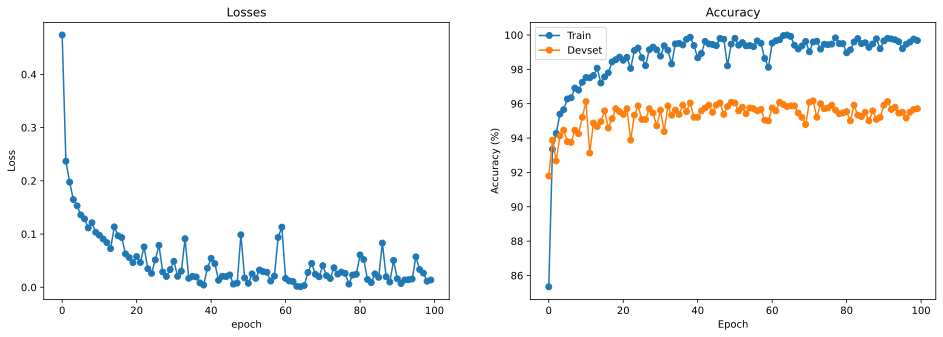

In [107]:
# plotting our outcomes
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(losses.detach(), 'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(train_acc, 'o-', label='Train')
ax[1].plot(dev_acc, 'o-', label='Devset')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
# ax[1].set_ylim([85,95])
# ax[1].set_xlim([80,105])
ax[1].legend()
plt.show()

In [108]:
# show the best model
# the_best_model

# Save the trained model
# save the model
torch.save(the_best_model['net'],'trained_model.pt')

In [109]:
# extract X,y from test dataloader
X,y = next(iter(test_loader))

In [113]:
# recreate the best-performing model
bestnet = create_the_model()[0]
# bestnet.load_state_dict(the_best_model['net'])
bestnet.load_state_dict(torch.load('trained_model.pt'))

<All keys matched successfully>

In [114]:
# and run the data through TEST
X,y = next(iter(test_loader))
y_hat = bestnet(X)

best_acc = 100 * torch.mean( ( torch.argmax(y_hat, axis=1) == y ).float() )
best_acc

tensor(95.2778)

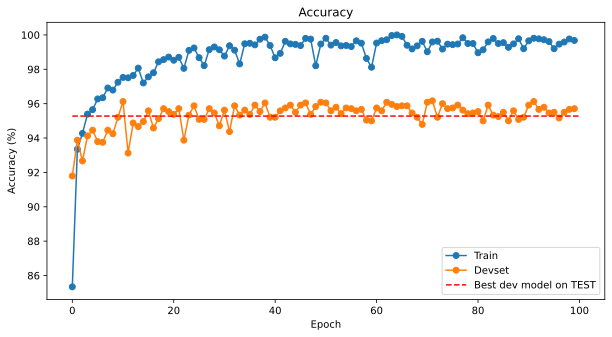

In [115]:
fig = plt.figure(figsize=(10,5))

plt.plot(train_acc, 'o-', label='Train')
plt.plot(dev_acc, 'o-', label='Devset')
plt.plot([0, len(dev_acc)], [best_acc, best_acc], 'r--', label='Best dev model on TEST')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy')
# plt.ylim([best_acc-5, best_acc+5])
plt.legend()
plt.show()